In [2]:
# Pulizia delle cache (rimuove se ci sono dataframe persistati)

#spark.catalog.clearCache()
import gc
gc.collect()

0

In [46]:
spark.stop()

In [4]:
SparkUI = 4040
# nicolò 4040
# marco  4041
# francesco 4042
# raffaele  4043
user = "user_a" # "user_a" "user_b" (B SE SI E' I SECONDI A LAVORARCI)
core = 16
Npartition = 4*core # Regola generale: numero_partizioni = numero_core * (2 o 4)

sudo pkill -u $(whoami) -f "jupyter-notebook"

# Setting Spark Session

In [5]:
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, TimestampType, BooleanType

from pyspark.sql.functions import (
    coalesce, corr, array, countDistinct, approx_count_distinct,
    col, lit, expr, when, count, count_if, row_number, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, lead, row_number, desc, asc, bool_or, floor,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id, mean
)

In [6]:
os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"

configs = {
   "spark.scheduler.mode": "FAIR",                                  # Multi-user scheduler
   "spark.scheduler.pool": user,                                    # User pool
   "spark.scheduler.allocation.file": "file:///usr/local/spark/conf/fairscheduler.xml",  # Scheduler config file
   "spark.executor.memory": "3000m",                                # Executor RAM
   "spark.cores.max": core,                                         # Total cores
   "spark.sql.shuffle.partitions": Npartition,                      # Shuffle partitions
   "spark.sql.execution.arrow.pyspark.enabled": "true",             # Enable Arrow
   "spark.sql.execution.arrow.pyspark.fallback.enabled": "false",   # No Arrow fallback
   "spark.dynamicAllocation.enabled": "false",                      # No dynamic allocation
   "spark.shuffle.service.enabled": "false",                        # No shuffle service
   "spark.ui.port": SparkUI,                                        # Custom UI port
   "spark.sql.debug.maxToStringFields": 1000                        # Debug fields limit
}

spark_builder = SparkSession.builder \
   .appName("ProjectCloudVeneto") \
   .master("spark://10.67.22.135:7077")

for key, value in configs.items():
   spark_builder = spark_builder.config(key, value)

spark = spark_builder.getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/18 17:09:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# SEGUENTI TRE CELLE SARANNO DA CANCELLARE SERVONO A NOI ORA PER LAVORARE (si crea e legge i vari df_final)

In [ ]:
# %%time
# -----  PER CREARE I FILES df_final DEGLI HW (SOVRASCRIVE IL FILE) -----
# try:
#     pandas_df = df_final.toPandas()
#     file_path = f"/mnt/shared/df_final_{hardware}.csv"
#     pandas_df.to_csv(file_path, index=False, header=True)
#     os.chmod(file_path, 0o775) # Imposta permessi
#     print(f"File creato e permessi impostati: {file_path}")
# except Exception as e:
#     print(f"Errore: {e}")

In [ ]:
# hardware = "SW-106"
# df_saved = spark.read.option("header", True).option("inferSchema", True).csv(f"/mnt/shared/df_final_{hardware}.csv").repartition(Npartition)
# df_casted = df_saved.select(*[col(c).cast("int").alias(c) if isinstance(f.dataType, DoubleType) else col(c) for c, f in zip(df_saved.columns, df_saved.schema.fields)])
# df_final = df_casted
# df_final = df_final.persist()
# df_final.count()

In [7]:
sensors = ['A5', 'A9', 'ComError', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
print(sensors)

['A5', 'A9', 'ComError', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


# Upload and inspect dataset

In [8]:
%%time 
df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv").repartition(Npartition)

# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

[Stage 1:======================================================>  (37 + 2) / 39]

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 19.5 s


In [9]:
# inspect dataset
df.printSchema()

root
 |-- when: integer (nullable = true)
 |-- hwid: string (nullable = true)
 |-- metric: string (nullable = true)
 |-- value: integer (nullable = true)



In [10]:
# inspect dataset
df.show(3, truncate=False)

[Stage 2:=======================================================> (38 + 1) / 39]

+----------+------+------+-----+
|when      |hwid  |metric|value|
+----------+------+------+-----+
|1606595137|SW-065|S181  |0    |
|1606389102|SW-065|SA12  |0    |
|1606158449|SW-065|P9    |300  |
+----------+------+------+-----+
only showing top 3 rows



In [11]:
# inspect hardwares of dataset
hwid_list = df.select("hwid").distinct()
hwid_list.show()

[Stage 7:================================================>        (55 + 9) / 64]

+------+
|  hwid|
+------+
|SW-088|
|SW-106|
|SW-115|
|SW-065|
+------+



In [12]:
%%time

hardware = "SW-088" 

df_hw = df.filter(col("hwid") == hardware)\
        .groupBy("when")\
        .pivot("metric")\
        .agg(first("value"))\
        .withColumn("time", from_unixtime(col("when")))\
        .orderBy("when") \
        .repartition(Npartition)

df_hw = df_hw.persist()

# show first 5 rows
engines = ["S117", "S118", "S169", "S170"]
df_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)

[Stage 48:================================================>       (55 + 9) / 64]

+----------+-------------------+----+----+----+----+
|      when|               time|S117|S118|S169|S170|
+----------+-------------------+----+----+----+----+
|1601510459|2020-10-01 00:00:59|   0|   0|NULL|NULL|
|1601510462|2020-10-01 00:01:02|NULL|NULL|   0|   0|
|1601510488|2020-10-01 00:01:28|   0|   0|NULL|NULL|
|1601510491|2020-10-01 00:01:31|NULL|NULL|   0|   0|
|1601510519|2020-10-01 00:01:59|   0|   0|NULL|NULL|
+----------+-------------------+----+----+----+----+
only showing top 5 rows

CPU times: user 52.2 ms, sys: 21.7 ms, total: 73.8 ms
Wall time: 51.2 s


In [13]:
df_hw.printSchema()

root
 |-- when: integer (nullable = true)
 |-- A5: integer (nullable = true)
 |-- A9: integer (nullable = true)
 |-- ComError: integer (nullable = true)
 |-- P1: integer (nullable = true)
 |-- P10: integer (nullable = true)
 |-- P15: integer (nullable = true)
 |-- P16: integer (nullable = true)
 |-- P17: integer (nullable = true)
 |-- P18: integer (nullable = true)
 |-- P2: integer (nullable = true)
 |-- P5: integer (nullable = true)
 |-- P6: integer (nullable = true)
 |-- P7: integer (nullable = true)
 |-- P8: integer (nullable = true)
 |-- P9: integer (nullable = true)
 |-- S1: integer (nullable = true)
 |-- S10: integer (nullable = true)
 |-- S100: integer (nullable = true)
 |-- S101: integer (nullable = true)
 |-- S102: integer (nullable = true)
 |-- S106: integer (nullable = true)
 |-- S107: integer (nullable = true)
 |-- S108: integer (nullable = true)
 |-- S109: integer (nullable = true)
 |-- S11: integer (nullable = true)
 |-- S110: integer (nullable = true)
 |-- S112: integer 

In [14]:
# Get sensors list
sensors = [field.name for field in df_hw.schema.fields 
           if field.name not in ["when", "time"] ]

print(sensors)

['A5', 'A9', 'ComError', 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']


# Timestamp analysis

In [15]:
def compute_time_differences(df, when_col="when", max_collect=1_000_000):
    rdd_times = df.select(when_col).rdd.map(lambda row: row[when_col])
    rdd_shifted = rdd_times.zipWithIndex().map(lambda x: (x[1], x[0]))  # (index, time)
    rdd_prev = rdd_shifted.map(lambda x: (x[0] + 1, x[1]))              # shift by +1 index
    rdd_joined = rdd_shifted.join(rdd_prev).sortByKey()
    rdd_diff = rdd_joined.map(lambda x: x[1][0] - x[1][1])

    num_diffs = rdd_diff.count()
    print(f"Number of time differences: {num_diffs}")

    if num_diffs < max_collect:
        return rdd_diff
    else:
        print("Too many differences to collect safely.")
        return None

In [16]:
def time_diff_summary(rdd_diff, spark, top_n=5):
    df_freq = rdd_diff.map(lambda d: (d, 1)) \
                      .reduceByKey(lambda a, b: a + b) \
                      .toDF(["diff", "count"]) \
                      .orderBy("diff")

    print(f"\n{top_n} smallest time differences:")
    df_freq.show(top_n, truncate=False)

    print(f"\n{top_n} largest time differences:")
    df_freq.orderBy("diff", ascending=False).show(top_n, truncate=False)

    return df_freq

In [17]:
# Compute time differences
rdd_diff = compute_time_differences(df_hw)

# Summarize and print top/bottom time gaps
df_diff_summary = time_diff_summary(rdd_diff, spark)

Number of time differences: 639868



5 smallest time differences:


+---------+-----+
|diff     |count|
+---------+-----+
|-15404895|1    |
|-15392290|1    |
|-15218196|1    |
|-15217218|1    |
|-14908772|1    |
+---------+-----+
only showing top 5 rows


5 largest time differences:
+--------+-----+
|diff    |count|
+--------+-----+
|13665378|1    |
|12092522|1    |
|11792242|1    |
|11206600|1    |
|11043736|1    |
+--------+-----+
only showing top 5 rows



In [18]:
def plot_diff_histogram(differences, min_diff, max_diff, delta):
    
    filtered = [d for d in differences if min_diff <= d <= max_diff]

    bins = int((max_diff - min_diff) / delta)

    plt.figure(figsize=(10, 6))
    plt.hist(filtered, bins=bins, color="steelblue", edgecolor="black")
    plt.title(f"Time Difference Events (range {min_diff} - {max_diff} [s])")
    plt.xlabel("Time difference [s]")
    plt.ylabel("Counts")
    plt.show()

In [19]:
diffs = rdd_diff.collect() # check previously the dimension

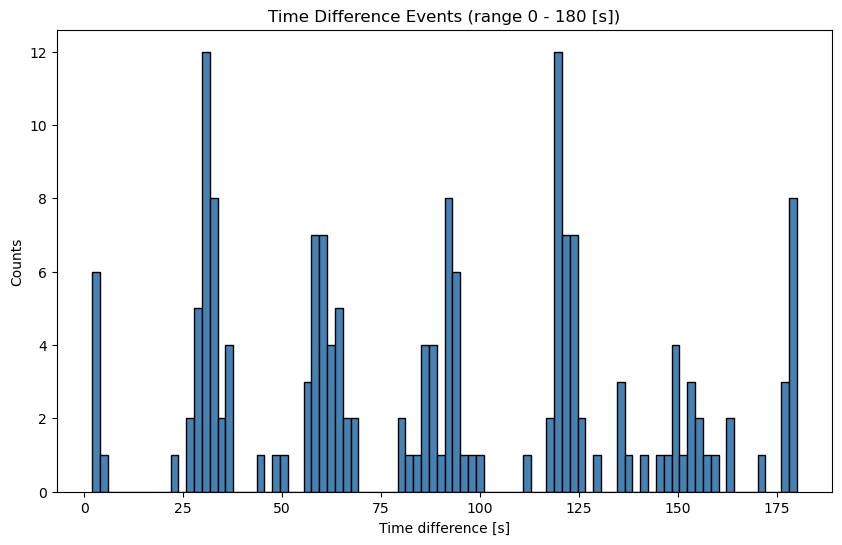

In [20]:
plot_diff_histogram(differences=diffs, min_diff=0, max_diff=180, delta=2)

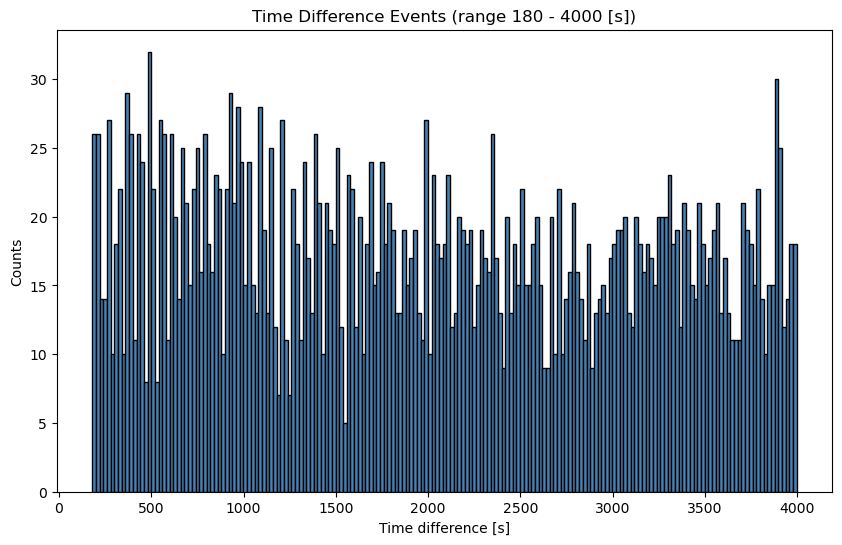

In [21]:
plot_diff_histogram(differences=diffs, min_diff=180, max_diff=4000, delta=20)

# Data preparation

In [22]:
def CreateGrid(df, interval):

    df_windowed = df.withColumn("time_window", window("time", f"{interval} seconds"))

    aggs = []
    sensors = [c for c in df.columns if c not in ("when", "time")]
    for s in sensors:
        stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
        is_binary = stats["min"] is not None and stats["max"] is not None    and    0 <= stats["min"] and stats["max"] <= 1
        if s in ["A5", "A9"] or is_binary:
            agg_func = spark_max(col(s)).alias(s)
        else:
            agg_func = spark_avg(col(s)).alias(s)
        aggs.append(agg_func)

    result_df = (
        df_windowed
        .groupBy("time_window")
        .agg(*aggs)
    )

    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    return result_df.select(["when","window_start","window_end"]+sensors)

In [23]:
%%time

interval = 60 #seconds

df_grid = CreateGrid(df_hw, interval)
df_grid = df_grid.persist()
df_grid.select("when","window_start","window_end",*engines).show(3, truncate = False)
df_hw.unpersist()

[Stage 1874:=========================================>           (50 + 14) / 64]

+----------+-------------------+-------------------+----+----+----+----+
|when      |window_start       |window_end         |S117|S118|S169|S170|
+----------+-------------------+-------------------+----+----+----+----+
|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|0   |0   |NULL|NULL|
|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|0   |0   |0   |0   |
|1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00|0   |0   |0   |0   |
+----------+-------------------+-------------------+----+----+----+----+
only showing top 3 rows

CPU times: user 221 ms, sys: 95.6 ms, total: 317 ms
Wall time: 24.3 s


DataFrame[when: int, A5: int, A9: int, ComError: int, P1: int, P10: int, P15: int, P16: int, P17: int, P18: int, P2: int, P5: int, P6: int, P7: int, P8: int, P9: int, S1: int, S10: int, S100: int, S101: int, S102: int, S106: int, S107: int, S108: int, S109: int, S11: int, S110: int, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: int, S123: int, S124: int, S125: int, S126: int, S127: int, S128: int, S129: int, S130: int, S137: int, S138: int, S140: int, S143: int, S147: int, S15: int, S151: int, S154: int, S157: int, S158: int, S159: int, S16: int, S163: int, S164: int, S165: int, S166: int, S167: int, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: int, S179: int, S180: int, S181: int, S183: int, S19: int, S2: int, S201: int, S202: int, S203: int, S204: int, S205: int, S206: int, S25: int, S3: int, S33: int, S34: int, S35: int, S37: int, S39: int, S40: int, S41: int, S42: int, S43: int, S45: int, S46: int,

In [24]:
def BuildBlocks(df, max_interval):
    w_global = Window.partitionBy(lit(1)).orderBy("when")
    df = (df
          .withColumn("Prev_TimeStamp", lag("when").over(w_global))
          .withColumn("Next_TimeStamp", lead("when").over(w_global))
          .withColumn("PrevDiff_s", col("when") - col("Prev_TimeStamp"))
          .withColumn("NextDiff_s", col("Next_TimeStamp") - col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn(
        "CheckNewBlock",
        when(col("PrevDiff_s") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", spark_sum("CheckNewBlock").over(w_global))

    #Copy these rows if there are any gaps (timediff > 60 but less than max_interval)
    skip_cols = {
        "when", "Prev_TimeStamp", "Next_TimeStamp",
        "PrevDiff_s", "NextDiff_s", "CheckNewBlock", "BlockID",
        "window_start", "window_end"}
    other_cols = [c for c in df.columns if c not in skip_cols]

    # Next values (lead) within EACH block to copy if there are gaps
    w_block = Window.partitionBy("BlockID").orderBy("when")
    for c in other_cols:
        df = df.withColumn(f"Next_{c}", lead(c).over(w_block))

    #Fill values only for intra-block gaps: 60 < gap < max_interval
    df = df.withColumn(
        "NumFill",
        when(
            (col("NextDiff_s") > 60) & (col("NextDiff_s") < max_interval),
            (floor(col("NextDiff_s")/60) - 1).cast("int")).otherwise(0))

    #Timestamps to insert between current and next row (every 60s)
    df = df.withColumn("FillTimestamps",
            when(col("NumFill") > 0,
                    expr("sequence(when + 60, Next_TimeStamp - 60, 60)")).otherwise(array()))

    #Artificial rows copy NEXT row's non-time columns
    fill_rows = (df
        .filter(col("NumFill") > 0)
        .select("BlockID",
            explode("FillTimestamps").alias("when"),
            *[col(f"Next_{c}").alias(c) for c in other_cols],
            lit(True).alias("is_artificial")))

    #Original rows
    original_rows = df.select("BlockID", "when", *other_cols, lit(False).alias("is_artificial"))

    #Union, order, recompute windows from 'when'
    final = ( original_rows.unionByName(fill_rows).orderBy("BlockID", "when") )

    # Recompute window_id and window bounds
    w_block_final = Window.partitionBy("BlockID").orderBy("when")
    final = (final
             .withColumn("window_id", row_number().over(w_block_final) - 1)
             .withColumn("window_start", from_unixtime(col("when") - 30))
             .withColumn("window_end",   from_unixtime(col("when") + 30)))

    #Recompute TimeDiff_s after filling
    final = (final
             .withColumn("PrevWhenInBlock", lag("when").over(w_block_final))
             .withColumn("TimeDiff_s",
                  when(col("PrevWhenInBlock").isNull(), lit(None).cast("int"))
                  .otherwise(col("when") - col("PrevWhenInBlock"))).drop("PrevWhenInBlock"))

    return final

In [25]:
%%time

df_blocks = BuildBlocks(df_grid, max_interval = 240)
df_blocks = spark.createDataFrame(df_blocks.rdd, df_blocks.schema)  # Break lineage
df_blocks = df_blocks.persist()
df_blocks.select("window_id", "when", "window_start", "window_end", "TimeDiff_s", "BlockID").show(3)
df_grid.unpersist()

[Stage 1958:==================================================>   (14 + 1) / 15]

+---------+----------+-------------------+-------------------+----------+-------+
|window_id|      when|       window_start|         window_end|TimeDiff_s|BlockID|
+---------+----------+-------------------+-------------------+----------+-------+
|        0|1601673750|2020-10-02 21:22:00|2020-10-02 21:23:00|      NULL|      9|
|        1|1601673810|2020-10-02 21:23:00|2020-10-02 21:24:00|        60|      9|
|        2|1601673870|2020-10-02 21:24:00|2020-10-02 21:25:00|        60|      9|
+---------+----------+-------------------+-------------------+----------+-------+
only showing top 3 rows

CPU times: user 125 ms, sys: 63.8 ms, total: 189 ms
Wall time: 42.5 s


DataFrame[when: bigint, window_start: timestamp, window_end: timestamp, A5: int, A9: int, ComError: int, P1: double, P10: double, P15: int, P16: double, P17: double, P18: double, P2: int, P5: double, P6: double, P7: double, P8: double, P9: double, S1: int, S10: double, S100: double, S101: double, S102: double, S106: int, S107: double, S108: int, S109: double, S11: int, S110: int, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: double, S123: double, S124: double, S125: double, S126: double, S127: int, S128: double, S129: double, S130: double, S137: double, S138: double, S140: double, S143: double, S147: double, S15: int, S151: double, S154: double, S157: double, S158: double, S159: double, S16: int, S163: int, S164: double, S165: int, S166: double, S167: int, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: double, S179: double, S180: double, S181: double, S183: int, S19: int, S2: double, S201: double, S202: 

Longest blocks:

      BlockID  minutes
1359      209     1422
1360      585     1434
1361      210     2073


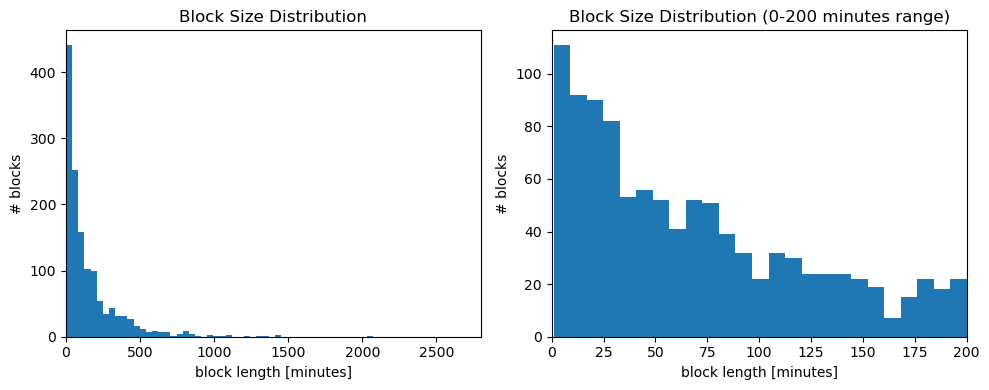

In [26]:
dist_blocks = df_blocks.groupBy("BlockID").agg(count("*").alias("minutes")).orderBy("minutes")
data = dist_blocks.toPandas()
print("Longest blocks:\n")
print( data.tail(3) )

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(data['minutes'], bins=50)
axes[0].set_xlim(0, 2800)
axes[0].set_xlabel("block length [minutes]")
axes[0].set_ylabel("# blocks")
axes[0].set_title("Block Size Distribution")

data_low_range = data[(data['minutes'] >= 0) & (data['minutes'] <= 200)]
axes[1].hist(data_low_range['minutes'], bins=25)
axes[1].set_xlim(0, 200)
axes[1].set_xlabel("block length [minutes]")
axes[1].set_ylabel("# blocks")
axes[1].set_title("Block Size Distribution (0-200 minutes range)")
plt.tight_layout()
plt.show()

# Anomaly detection

In [27]:
def detect_anomalies(df, time_separator, threshold, sensors, extended = False, debug = False):
    # Lag to get previous value within each partition (i.e. within each block)
    window         = Window.partitionBy("BlockID").orderBy("window_id")
    lagged_columns = [lag(col(s)).over(window) for s in sensors] 
    lag_names      = [f"lagged_{s}" for s in sensors]

    df_interest = df.select("BlockID","window_id","when",*sensors)
    df_lagged = df_interest.withColumns(dict(zip(lag_names, lagged_columns)))

    # Determina switch del sensore (didSwitch = 1 se il sensore passa da 0 a 1 o viceversa, didSwitch = 0 altrimenti)
    switch_w     = Window.partitionBy('BlockID').orderBy('window_id')
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect anomaly group: when two clusters are more distant than time_separator they are grouped as different anomalies
    # Tutte le anomalie di uno stesso gruppo hanno stesso id, cioè un numero crescente che si resetta ad ogni nuovo blocco
    df_anomalies = df_didSwitch
    for sensor in sensors:   
        # Il periodo anomalo inizia quando il sensore è 1 e finisce quando esso è 0
        df_start = (
            df_didSwitch \
            .withColumn(f'theres0Before_{sensor}', count_if(col(sensor) == 0).over(window.rowsBetween(1, int(time_separator/60))) > 0) \
            .withColumn(f'theres0After_{sensor}', count_if(col(sensor) == 0).over(window.rowsBetween(-int(time_separator/60), -1)) > 0) \
            .filter( 
                (col(f'didSwitch_{sensor}') == 1) & 
                (when(col(sensor) == 1, col(f'theres0Before_{sensor}')).otherwise(True)) &
                (when(col(sensor) == 0, col(f'theres0After_{sensor}')).otherwise(True))
            ) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -1e9).over(window))>time_separator, 1).otherwise(0)) \
            .withColumn(f'anomalyID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(window)) \
        )
        
        df_anomalies = df_anomalies.join(
            other = df_start.select('BlockID', 'window_id', f'startGroup_{sensor}', f'anomalyID_{sensor}'),
            on = ['BlockID', 'window_id'],
            how = 'left'
        )

    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'anomalyID_{s}')) for s in sensors]

    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') >= threshold) & (col(f'anomalyID_{s}') > 0), True).otherwise(False) for s in sensors]
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('BlockID', 'window_id')

    # anomaly condition: just one of the engines had an anomaly
    condition = sum(col(f).cast('int') for f in flag_names) > 0
    df_flag = df_flag.withColumn( "flag_anomaly", when(condition, 1).otherwise(0).cast('int'))

        
    if debug:
        next_w  = Window.partitionBy('BlockID').orderBy('window_id').rowsBetween(0, int(time_separator/60))
        prev_w  = Window.partitionBy('BlockID').orderBy('window_id').rowsBetween(-int(time_separator/60), 0)
        prev_names = [f'prevID_{s}' for s in sensors]
        prev_id = [when((bool_or(f'flag_{s}').over(prev_w)), spark_max(f'anomalyID_{s}').over(prev_w)).otherwise(None) for s in sensors]
        next_names = [f'nextID_{s}' for s in sensors]
        next_id = [when((bool_or(f'flag_{s}').over(next_w)), spark_min(f'anomalyID_{s}').over(next_w)).otherwise(None) for s in sensors]

        df_newID = (
            df_flag.withColumns(dict(zip(prev_names, prev_id))).withColumns(dict(zip(next_names, next_id)))
        )

        new_flags = [when((col(f'nextID_{s}') == col(f'prevID_{s}')) & (col(f'nextID_{s}') > 0), True).otherwise(col(f'flag_{s}')) for s in sensors]   
        df_flag = df_newID.withColumns(dict(zip(flag_names, new_flags)))

        return df_flag .select("BlockID", "window_id", "when", 'S117' ,'didSwitch_S117','startGroup_S117','anomalyID_S117','count_S117', 'flag_S117', 'prevID_S117', 'nextID_S117')
    
    else:
        return df_flag .select("BlockID", "window_id", "when", *sensors, *flag_names, "flag_anomaly")

In [28]:
%%time

# preatty heavy to look better into detect_anomalies() function
df_anomalies = detect_anomalies(
    df = df_blocks,
    time_separator = 60*30, # seconds
    threshold = 6,
    sensors = engines,
    debug = False
)

CPU times: user 29.2 ms, sys: 9.27 ms, total: 38.5 ms
Wall time: 321 ms


In [29]:
%%time

df_anomalies = spark.createDataFrame(df_anomalies.rdd, df_anomalies.schema)  # Break lineage
df_anomalies = df_anomalies.persist()
# see which block had an anomaly regarding engine "S117"
df_anomalies.filter('flag_S117').show(3, truncate=False)

+-------+---------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|BlockID|window_id|when      |S117|S118|S169|S170|flag_S117|flag_S118|flag_S169|flag_S170|flag_anomaly|
+-------+---------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|102    |148      |1602568710|1   |0   |1   |1   |true     |true     |false    |false    |1           |
|102    |150      |1602568830|0   |0   |0   |1   |true     |false    |false    |false    |1           |
|102    |168      |1602570090|1   |0   |0   |1   |true     |true     |false    |false    |1           |
+-------+---------+----------+----+----+----+----+---------+---------+---------+---------+------------+
only showing top 3 rows

CPU times: user 11.4 ms, sys: 735 μs, total: 12.1 ms
Wall time: 3.94 s


In [30]:
def inspect_anomalies(df, sensor, blockID):

    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, sensor, 0)
    anomalies = extract_column(df, f'flag_{sensor}', False)
    t = range(len(anomalies))

    plt.bar(t, values, width = 1, alpha = 0.5, edgecolor=None, lw=1)
    plt.bar(t, anomalies, width= 1, alpha = 0.5, label="anomaly period")
    plt.xlabel("Minutes")
    plt.ylabel(sensor)
    plt.legend(loc='lower right')
    plt.title(f"Block N.{blockID}")
    plt.legend()
    plt.show()

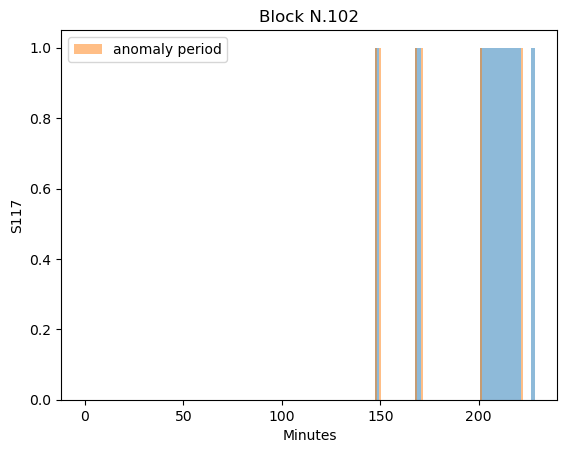

In [31]:
inspect_anomalies(df_anomalies, 'S117', 102)

In [32]:
# Join on `when` and take just `flag_anomaly`

df_anom = df_anomalies.select('when', 'flag_anomaly')
df_anom = spark.createDataFrame(df_anom.rdd, df_anom.schema)  # Break lineage
df_blocks_anom = df_blocks.join( df_anom, on='when', how='left' )
df_blocks_anom = df_blocks_anom.persist()
df_blocks_anom.show(1)

df_blocks.unpersist()

[Stage 2255:===========================================>          (52 + 8) / 64]

+----------+-------+----+----+--------+---+-----+---+-----+-----+-----+---+-----+-----+-----+-----+-----+---+---+-----+-----+-----+----+-----+----+-----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+-----+----+----+-----+-----+---+----+----+-----+-----+-----+---+----+-----+----+-----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+---+---+------+------+------+------+------+------+---+-----+---+---+---+---+-----+-----+-----+---+---+---+-----+-----+---+---+---+---+---+---+---+---+-----+---+---+---+---+---+-----+-----+---+---+-----+----+-----+---+---+---+---+-----+---+----+----+----+---+---+---+-------+---+---+---+---+---+-------------+---------+-------------------+-------------------+----------+------------+
|      when|BlockID|  A5|  A9|ComError| P1|  P10|P15|  P16|  P17|  P18| P2|   P5|   P6|   P7|   P8|   P9| S1|S10| S100| S101| S102|S106| S107|S108| S109|S11|S110|S112|S113|S114|S115|S117|S118|S122|S123|S124|S125|S126|S

DataFrame[BlockID: bigint, when: bigint, A5: int, A9: int, ComError: int, P1: double, P10: double, P15: int, P16: double, P17: double, P18: double, P2: int, P5: double, P6: double, P7: double, P8: double, P9: double, S1: int, S10: double, S100: double, S101: double, S102: double, S106: int, S107: double, S108: int, S109: double, S11: int, S110: int, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: double, S123: double, S124: double, S125: double, S126: double, S127: int, S128: double, S129: double, S130: double, S137: double, S138: double, S140: double, S143: double, S147: double, S15: int, S151: double, S154: double, S157: double, S158: double, S159: double, S16: int, S163: int, S164: double, S165: int, S166: double, S167: int, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: double, S179: double, S180: double, S181: double, S183: int, S19: int, S2: double, S201: double, S202: double, S203: double, S204: dou

# A5 A9 Alarms

In [33]:
def extract_alarms(df: DataFrame, columns=["A5", "A9"], bits=[6, 7, 8]) -> DataFrame:
    for col_name in columns:
        for bit in bits:
            convert_bit = bit - 1  # bit 1 is LSB
            df = df.withColumn( f"{bit}-{col_name}", ((col(col_name).bitwiseAND(1 << convert_bit)) > 0).cast("int") )
    
    all_bit_cols = [col(f"{bit}-{col_name}") for col_name in columns for bit in bits]
    
    # condition ad least one alarm to get overheating
    condition = sum(all_bit_cols) > 0 # already menaged NULL, it gives 0
    df = df.withColumn("overheating", when(condition, 1).otherwise(0).cast("int"))
 
    return df

In [34]:
# Extract bits from alarms
df_alarms = extract_alarms(df_blocks_anom.select("when","A5","A9"), columns=["A5", "A9"], bits=[6, 7, 8])

df_alarms.show(3)
df_alarms.where( (col("A5").isNotNull()) | (col("A9").isNotNull()) ).show(3)
df_alarms.where( col("overheating") == 1 ).show(3)

+----------+----+----+----+----+----+----+----+----+-----------+
|      when|  A5|  A9|6-A5|7-A5|8-A5|6-A9|7-A9|8-A9|overheating|
+----------+----+----+----+----+----+----+----+----+-----------+
|1601673870|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|          0|
|1601677770|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|          0|
|1601678910|NULL|NULL|NULL|NULL|NULL|NULL|NULL|NULL|          0|
+----------+----+----+----+----+----+----+----+----+-----------+
only showing top 3 rows

+----------+----+----+----+----+----+----+----+----+-----------+
|      when|  A5|  A9|6-A5|7-A5|8-A5|6-A9|7-A9|8-A9|overheating|
+----------+----+----+----+----+----+----+----+----+-----------+
|1602376050|   0|   0|   0|   0|   0|   0|   0|   0|          0|
|1603240110|   0|   0|   0|   0|   0|   0|   0|   0|          0|
|1611813750|NULL|8256|NULL|NULL|NULL|   0|   1|   0|          0|
+----------+----+----+----+----+----+----+----+----+-----------+
only showing top 3 rows

+----------+---+---+----+----+----+----+

In [35]:
# add overheating columns in order to obtain final df ( all sensors + anomaly + overheating )

df_blocks_anom_alarm = df_blocks_anom.join( df_alarms.select('when', 'overheating') , on='when', how='left' )
df_final = spark.createDataFrame(df_blocks_anom_alarm.rdd, df_blocks_anom_alarm.schema)  # Break lineage
df_final = df_final.persist()
df_final.show(1)

df_blocks_anom.unpersist()

25/08/18 17:14:13 WARN DAGScheduler: Broadcasting large task binary with size 1054.8 KiB
25/08/18 17:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1077.0 KiB


+----------+-------+----+----+--------+---+-----+---+-----+-----+-----+---+-----+-----+-----+-----+-----+---+---+-----+-----+-----+----+-----+----+-----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+-----+----+----+-----+-----+---+----+----+-----+-----+-----+---+----+-----+----+-----+----+----+---+----+----+----+----+----+----+----+----+----+-------+----+----+---+---+------+------+------+------+------+------+---+-----+---+---+---+---+-----+-----+-----+---+---+---+-----+-----+---+---+---+---+---+---+---+---+-----+---+---+---+---+---+-----+-----+---+---+-----+-----+-----+---+---+---+---+-----+---+----+----+----+---+---+---+-------+---+---+---+---+---+-------------+---------+-------------------+-------------------+----------+------------+-----------+
|      when|BlockID|  A5|  A9|ComError| P1|  P10|P15|  P16|  P17|  P18| P2|   P5|   P6|   P7|   P8|   P9| S1|S10| S100| S101| S102|S106| S107|S108| S109|S11|S110|S112|S113|S114|S115|S117|S118|S122|S123|

DataFrame[when: bigint, BlockID: bigint, A5: int, A9: int, ComError: int, P1: double, P10: double, P15: int, P16: double, P17: double, P18: double, P2: int, P5: double, P6: double, P7: double, P8: double, P9: double, S1: int, S10: double, S100: double, S101: double, S102: double, S106: int, S107: double, S108: int, S109: double, S11: int, S110: int, S112: int, S113: int, S114: int, S115: int, S117: int, S118: int, S122: double, S123: double, S124: double, S125: double, S126: double, S127: int, S128: double, S129: double, S130: double, S137: double, S138: double, S140: double, S143: double, S147: double, S15: int, S151: double, S154: double, S157: double, S158: double, S159: double, S16: int, S163: int, S164: double, S165: int, S166: double, S167: int, S169: int, S17: int, S170: int, S171: int, S172: int, S173: int, S174: int, S175: int, S176: int, S178: double, S179: double, S180: double, S181: double, S183: int, S19: int, S2: double, S201: double, S202: double, S203: double, S204: dou

# Correlations setup ( anomaly, S125-S181, A5-A9)

In [36]:
# consider only changing sensors for correlations tasks

real_sensors = [s for s in sensors if s not in ["A5", "A9", *engines]]

counts = df_final.agg(*(countDistinct(c).alias(c) for c in real_sensors)).first().asDict()

useful_sensors = [c for c, v in counts.items() if v > 1]

25/08/18 17:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1378.3 KiB
25/08/18 17:17:17 WARN DAGScheduler: Broadcasting large task binary with size 1556.5 KiB
25/08/18 17:17:19 WARN DAGScheduler: Broadcasting large task binary with size 1670.4 KiB
                                                                                

In [37]:
print(f"There are {len(useful_sensors)} sensors with more than one distinct values")
print(useful_sensors)

There are 97 sensors with more than one distinct values
['ComError', 'P1', 'P10', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA2', 'SA3', 'SA5', 'SA7', 'SA9']


In [38]:
def correlations(df, sensors_list, target_col, batch_size=25):
    """
    Compute correlations between sensors and target column in batches.
    Returns sorted DataFrame by absolute correlation (descending).
    """   
    all_correlations = []
    
    # Process sensors in batches to avoid broadcasting large tasks
    for i in range(0, len(sensors_list), batch_size):
        batch_sensors = sensors_list[i:i + batch_size]
        
        # Create correlation expressions for current batch
        corr_expressions = [corr(target_col, sensor).alias(f"corr_{sensor}") for sensor in batch_sensors]
        
        # Execute correlations for this batch
        batch_results = df.agg(*corr_expressions).collect()[0]
        
        # Extract correlation values (handle nulls as 0.0)
        batch_correlations = [batch_results[f"corr_{sensor}"] or 0.0 
                            for sensor in batch_sensors]
        all_correlations.extend(batch_correlations)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        "Sensors": sensors_list, 
        "Correlations": all_correlations
    })
    
    # Sort by absolute correlation (highest first)
    sorted_results = results_df.reindex(
        results_df["Correlations"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    
    return sorted_results

In [39]:
def plot_correlations(df_spark, target_col, feature_cols, corr_df):
    import matplotlib.pyplot as plt
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_str = f"{corr_val[0]:.3f}" if len(corr_val) > 0 else "N/A"
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.scatter(pd_df[feature], pd_df[target_col], color="steelblue", alpha=0.005)
        ax1.set_ylabel(target_col)
        
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax2.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        ax2.set_ylabel("Density")
        ax2.legend()
        
        fig.suptitle(f"{feature} - Correlation: {corr_str}")
        plt.tight_layout()
        plt.show()

### PCA

In [43]:
df_anomalies_n = df_final
df_anomalies_n = df_anomalies_n.select(useful_sensors)
df_anomalies_n.printSchema()
df_anomalies_n.show(5)

root
 |-- ComError: integer (nullable = true)
 |-- P1: double (nullable = true)
 |-- P10: double (nullable = true)
 |-- P16: double (nullable = true)
 |-- P17: double (nullable = true)
 |-- P18: double (nullable = true)
 |-- P2: integer (nullable = true)
 |-- P5: double (nullable = true)
 |-- P6: double (nullable = true)
 |-- P7: double (nullable = true)
 |-- P8: double (nullable = true)
 |-- P9: double (nullable = true)
 |-- S1: integer (nullable = true)
 |-- S10: double (nullable = true)
 |-- S100: double (nullable = true)
 |-- S101: double (nullable = true)
 |-- S102: double (nullable = true)
 |-- S107: double (nullable = true)
 |-- S109: double (nullable = true)
 |-- S112: integer (nullable = true)
 |-- S113: integer (nullable = true)
 |-- S114: integer (nullable = true)
 |-- S115: integer (nullable = true)
 |-- S122: double (nullable = true)
 |-- S123: double (nullable = true)
 |-- S124: double (nullable = true)
 |-- S125: double (nullable = true)
 |-- S126: double (nullable = tru

In [44]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

def covariance_matrix(df, cols=None):
    """
    This function returns the covariance matrix from the df
    """
    
    if cols is None:
        cols = df.columns

    for c in cols:
        df = df.withColumn(c, col(c).cast(DoubleType()))
    
    means = df.select([mean(c).alias(c) for c in cols]).collect()[0].asDict()
    
    df_centered = df.select(*[(col(c) - means[c]).alias(c) for c in cols])
    
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    df_centered_vec = assembler.transform(df_centered).select("features")
    
    n = df.count()
    cov_matrix = (
        df_centered_vec.rdd
        .map(lambda row: row.features.toArray())
        .map(lambda x: np.outer(x, x))
        .reduce(lambda a, b: a + b) / (n - 1)
    )
    
    return cov_matrix, cols

cov_matrix, columns = covariance_matrix(df_anomalies_n)

print("Columns:", columns)
print("Covariance matrix:\n", cov_matrix)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 2668.0 failed 4 times, most recent failure: Lost task 9.3 in stage 2668.0 (TID 11646) (10.67.22.135 executor 0): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4745/0x00007fe25902e2a8`: (struct<ComError:double,P1:double,P10:double,P16:double,P17:double,P18:double,P2:double,P5:double,P6:double,P7:double,P8:double,P9:double,S1:double,S10:double,S100:double,S101:double,S102:double,S107:double,S109:double,S112:double,S113:double,S114:double,S115:double,S122:double,S123:double,S124:double,S125:double,S126:double,S127:double,S128:double,S129:double,S130:double,S137:double,S138:double,S140:double,S143:double,S147:double,S151:double,S154:double,S157:double,S158:double,S159:double,S164:double,S166:double,S171:double,S172:double,S173:double,S174:double,S178:double,S179:double,S180:double,S181:double,S183:double,S2:double,S201:double,S202:double,S203:double,S204:double,S205:double,S206:double,S25:double,S3:double,S33:double,S35:double,S37:double,S39:double,S40:double,S41:double,S46:double,S47:double,S5:double,S53:double,S55:double,S6:double,S64:double,S7:double,S70:double,S71:double,S72:double,S73:double,S8:double,S80:double,S81:double,S83:double,S86:double,S9:double,S90:double,S94:double,S97:double,SA1:double,SA10:double,SA11:double,SA2:double,SA3:double,SA5:double,SA7:double,SA9:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.ContextAwareIterator.hasNext(ContextAwareIterator.scala:39)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:86)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:80)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 14 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4745/0x00007fe25902e2a8`: (struct<ComError:double,P1:double,P10:double,P16:double,P17:double,P18:double,P2:double,P5:double,P6:double,P7:double,P8:double,P9:double,S1:double,S10:double,S100:double,S101:double,S102:double,S107:double,S109:double,S112:double,S113:double,S114:double,S115:double,S122:double,S123:double,S124:double,S125:double,S126:double,S127:double,S128:double,S129:double,S130:double,S137:double,S138:double,S140:double,S143:double,S147:double,S151:double,S154:double,S157:double,S158:double,S159:double,S164:double,S166:double,S171:double,S172:double,S173:double,S174:double,S178:double,S179:double,S180:double,S181:double,S183:double,S2:double,S201:double,S202:double,S203:double,S204:double,S205:double,S206:double,S25:double,S3:double,S33:double,S35:double,S37:double,S39:double,S40:double,S41:double,S46:double,S47:double,S5:double,S53:double,S55:double,S6:double,S64:double,S7:double,S70:double,S71:double,S72:double,S73:double,S8:double,S80:double,S81:double,S83:double,S86:double,S9:double,S90:double,S94:double,S97:double,SA1:double,SA10:double,SA11:double,SA2:double,SA3:double,SA5:double,SA7:double,SA9:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.ContextAwareIterator.hasNext(ContextAwareIterator.scala:39)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.hasNext(SerDeUtil.scala:86)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.foreach(SerDeUtil.scala:80)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:322)
	at org.apache.spark.api.python.PythonRunner$$anon$2.writeIteratorToStream(PythonRunner.scala:751)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:451)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:282)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 14 more


In [ ]:
def pca_from_cov(cov_matrix, cols, verbose = False):
    """
    PCA from covariance matrix
    """
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    explained_var_ratio = eigvals / eigvals.sum()

    if verbose:
        print("Covariance matrix:\n", cov_matrix, "\n")
        print("Eigenvalues (variance explained):", eigvals)
        print("Explained variance ratio:", explained_var_ratio, "\n")
        print("Principal Components (eigenvectors):")
        for i in range(len(cols)):
            print(f"PC{i+1} ({explained_var_ratio[i]*100:.2f}% variance):")
            for col, weight in zip(cols, eigvecs[:, i]):
                print(f"  {col}: {weight:.4f}")
            print()


pca_from_cov(cov_matrix, columns, verbose = True)

# Anomaly correlations (S117,S118,S169,S170)

In [ ]:
%%time

anomaly_corr = correlations(df_final.select(*useful_sensors,"flag_anomaly"), useful_sensors, "flag_anomaly")
top_anomaly_corr = anomaly_corr.head(5)["Sensors"].tolist()

In [ ]:
anomaly_corr.head(5)

In [ ]:
plot_correlations( df_final, "flag_anomaly", top_anomaly_corr, anomaly_corr )

# Device load vs Eternal temperature (S125-S181 vs S41)

# A5 e A9 alarms

In [ ]:
%%time

alarm_corr = correlations(df_final.select(*useful_sensors,"overheating"), useful_sensors, "overheating")
alarm_corr.head(5)
top_alarm_corr = alarm_corr.head(5)["Sensors"].tolist()

In [ ]:
plot_correlations( df_final, "overheating", top_alarm_corr, alarm_corr )

# Predictive Maintenance

# <hr style="height:4px; background-color:black; border:none;" />